# 🚀 Apache Spark + Scikit-learn + MLflow Integration

Ten notatnik demonstruje pełny potok uczenia maszynowego z najnowszym MLflow 2.19.0!

🎯 **Pełna integracja:**
- ✅ Feature Engineering w Apache Spark
- ✅ Trenowanie modeli w Scikit-learn  
- ✅ Tracking eksperymentów w MLflow (HTTP Server)
- ✅ Model serving przez MLflow REST API
- ✅ Inferencja w czasie rzeczywistym

**📡 MLflow Server:** http://localhost:5000

---

# Integracja Apache Spark + Scikit-learn + MLflow

Ten notatnik demonstruje pełny potok uczenia maszynowego, gdzie:
- **Feature Engineering** - wykonywany w Apache Spark
- **Budowa i trenowanie modelu** - w Scikit-learn  
- **Śledzenie eksperymentów** - za pomocą MLflow
- **Wyserwowanie modelu** - przez MLflow REST API

## Architektura potoku:
1. Ładowanie i przetwarzanie danych w Spark
2. Feature engineering w Spark
3. Eksport do Pandas/Scikit-learn
4. Trenowanie modelu
5. Rejestracja w MLflow
6. Wyserwowanie i inferencja

## 1. Importowanie bibliotek

Zaczynamy od zaimportowania wszystkich wymaganych bibliotek:

In [12]:
# Import podstawowych bibliotek
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import requests
import json
from datetime import datetime

# Import Spark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, isnan, count, mean, stddev
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml import Pipeline

# Import Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler as SklearnScaler

# Import MLflow
import mlflow
import mlflow.sklearn
import mlflow.spark
from mlflow.tracking import MlflowClient

warnings.filterwarnings('ignore')
print("Wszystkie biblioteki zostały zaimportowane pomyślnie!")

Wszystkie biblioteki zostały zaimportowane pomyślnie!


## 2. Konfiguracja Apache Spark

Tworzymy sesję Spark z odpowiednią konfiguracją:

In [13]:
# Konfiguracja i utworzenie sesji Spark
spark = SparkSession.builder \
    .appName("SparkMLflowIntegration") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .getOrCreate()

# Ustawienie poziomu logowania na WARN aby zmniejszyć verbose output
spark.sparkContext.setLogLevel("WARN")

print(f"Spark wersja: {spark.version}")
print(f"Spark UI dostępne pod: {spark.sparkContext.uiWebUrl}")
print("Sesja Spark została uruchomiona pomyślnie!")

Spark wersja: 3.5.1
Spark UI dostępne pod: http://ea4ef6fe-38ad-498d-a623-c4105de0cf2f.internal.cloudapp.net:4040
Sesja Spark została uruchomiona pomyślnie!


## 3. Przygotowanie danych w Spark

Generujemy przykładowe dane do demonstracji (w rzeczywistości można załadować dane z różnych źródeł jak HDFS, S3, bazy danych, itp.):

In [14]:
# Generowanie przykładowych danych do demonstracji
# W rzeczywistości dane mogą pochodzić z HDFS, S3, baz danych, etc.

np.random.seed(42)
n_samples = 10000

# Generujemy dane dla zadania klasyfikacji binarnej (predykcja churn klientów)
data = {
    'customer_id': range(1, n_samples + 1),
    'age': np.random.normal(40, 15, n_samples),
    'income': np.random.lognormal(10, 0.5, n_samples),
    'tenure_months': np.random.randint(1, 72, n_samples),
    'monthly_charges': np.random.normal(65, 20, n_samples),
    'total_charges': None,  # Wypełnimy to później
    'contract_type': np.random.choice(['Month-to-month', 'One year', 'Two year'], n_samples, p=[0.5, 0.3, 0.2]),
    'payment_method': np.random.choice(['Electronic check', 'Mailed check', 'Bank transfer', 'Credit card'], n_samples),
    'internet_service': np.random.choice(['DSL', 'Fiber optic', 'No'], n_samples, p=[0.4, 0.4, 0.2]),
    'online_security': np.random.choice(['Yes', 'No'], n_samples, p=[0.3, 0.7]),
    'tech_support': np.random.choice(['Yes', 'No'], n_samples, p=[0.3, 0.7]),
    'num_services': np.random.randint(1, 8, n_samples)
}

# Obliczamy total_charges na podstawie monthly_charges i tenure_months
data['total_charges'] = data['monthly_charges'] * data['tenure_months'] + np.random.normal(0, 50, n_samples)

# Tworzymy zmienną docelową (churn) na podstawie logicznych zależności
churn_probability = (
    0.1 +  # baseline
    0.3 * (np.array(data['contract_type']) == 'Month-to-month') +
    0.2 * (np.array(data['monthly_charges']) > 80) +
    0.15 * (np.array(data['tenure_months']) < 12) +
    0.1 * (np.array(data['online_security']) == 'No') -
    0.1 * (np.array(data['num_services']) > 5)
)

data['churn'] = np.random.binomial(1, np.clip(churn_probability, 0, 1), n_samples)

# Konwertujemy do pandas DataFrame, a następnie do Spark DataFrame
pandas_df = pd.DataFrame(data)
spark_df = spark.createDataFrame(pandas_df)

print(f"Dane zostały wygenerowane: {spark_df.count()} wierszy, {len(spark_df.columns)} kolumn")
print("\nPodgląd danych:")
spark_df.show(5, truncate=False)

Dane zostały wygenerowane: 10000 wierszy, 13 kolumn

Podgląd danych:
+-----------+------------------+------------------+-------------+------------------+------------------+--------------+--------------+----------------+---------------+------------+------------+-----+
|customer_id|age               |income            |tenure_months|monthly_charges   |total_charges     |contract_type |payment_method|internet_service|online_security|tech_support|num_services|churn|
+-----------+------------------+------------------+-------------+------------------+------------------+--------------+--------------+----------------+---------------+------------+------------+-----+
|1          |47.450712295168486|15689.588755259461|32           |45.415656555963366|1375.8562550134955|Two year      |Mailed check  |DSL             |No             |Yes         |6           |1    |
|2          |37.92603548243223 |18906.296022782655|18           |46.108162337332296|856.931208506565  |Month-to-month|Credit card   |No

In [15]:
# Podstawowa analiza danych w Spark
print("=== ANALIZA DANYCH W SPARK ===")

# Schema danych
print("\n1. Schema danych:")
spark_df.printSchema()

# Statystyki opisowe
print("\n2. Statystyki opisowe dla zmiennych numerycznych:")
numeric_cols = ['age', 'income', 'tenure_months', 'monthly_charges', 'total_charges', 'num_services']
spark_df.select(numeric_cols).describe().show()

# Rozkład zmiennej docelowej
print("\n3. Rozkład zmiennej docelowej (churn):")
spark_df.groupBy('churn').count().orderBy('churn').show()

# Sprawdzanie brakujących wartości
print("\n4. Sprawdzanie brakujących wartości:")
for col_name in spark_df.columns:
    null_count = spark_df.filter(col(col_name).isNull() | isnan(col(col_name))).count()
    print(f"{col_name}: {null_count} brakujących wartości")

=== ANALIZA DANYCH W SPARK ===

1. Schema danych:
root
 |-- customer_id: long (nullable = true)
 |-- age: double (nullable = true)
 |-- income: double (nullable = true)
 |-- tenure_months: long (nullable = true)
 |-- monthly_charges: double (nullable = true)
 |-- total_charges: double (nullable = true)
 |-- contract_type: string (nullable = true)
 |-- payment_method: string (nullable = true)
 |-- internet_service: string (nullable = true)
 |-- online_security: string (nullable = true)
 |-- tech_support: string (nullable = true)
 |-- num_services: long (nullable = true)
 |-- churn: long (nullable = true)


2. Statystyki opisowe dla zmiennych numerycznych:


+-------+-------------------+------------------+------------------+-------------------+------------------+----------------+
|summary|                age|            income|     tenure_months|    monthly_charges|     total_charges|    num_services|
+-------+-------------------+------------------+------------------+-------------------+------------------+----------------+
|  count|              10000|             10000|             10000|              10000|             10000|           10000|
|   mean|   39.9679602494736| 25135.34417179322|           36.1782|  64.98019826082334|2343.6859218430714|          3.9853|
| stddev| 15.051935707551065|13466.548834860287|20.586306719818307| 19.926423918092087|1556.4893898379698|2.00526457571111|
|    min|-18.836003774275135|3202.9013035436883|                 1|-24.308996860719077|-155.4275295087059|               1|
|    max|   98.8935655965449|206807.17689032175|                71| 146.98900665867842| 9366.482019469073|               7|
+-------

## 4. Feature Engineering w Apache Spark

Wykonujemy transformacje danych i przygotowanie cech w Spark:

In [16]:
# Feature Engineering w Spark
print("=== FEATURE ENGINEERING W SPARK ===")

# 1. Tworzenie nowych cech (feature creation)
from pyspark.sql.functions import when, col, log, sqrt

spark_df_features = spark_df \
    .withColumn('avg_monthly_charge', col('total_charges') / col('tenure_months')) \
    .withColumn('high_value_customer', when(col('monthly_charges') > 70, 1).otherwise(0)) \
    .withColumn('long_tenure', when(col('tenure_months') > 24, 1).otherwise(0)) \
    .withColumn('income_log', log(col('income') + 1)) \
    .withColumn('charges_per_service', col('monthly_charges') / col('num_services')) \
    .withColumn('age_group', 
                when(col('age') < 30, 'Young')
                .when(col('age') < 50, 'Middle')
                .otherwise('Senior'))

print("\n1. Nowe cechy utworzone:")
print("- avg_monthly_charge: średnia miesięczna opłata")
print("- high_value_customer: klient o wysokiej wartości (binary)")
print("- long_tenure: długi czas korzystania z usług (binary)")
print("- income_log: logarytm dochodu")
print("- charges_per_service: opłata na usługę")
print("- age_group: grupa wiekowa (kategoryczna)")

# 2. Kodowanie zmiennych kategorycznych za pomocą StringIndexer
from pyspark.ml.feature import StringIndexer

categorical_cols = ['contract_type', 'payment_method', 'internet_service', 'online_security', 'tech_support', 'age_group']
indexers = []
for col_name in categorical_cols:
    indexer = StringIndexer(inputCol=col_name, outputCol=f"{col_name}_indexed")
    indexers.append(indexer)

print(f"\n2. Kodowanie {len(categorical_cols)} zmiennych kategorycznych")

# 3. Wybór cech numerycznych do skalowania
numeric_features = ['age', 'income_log', 'tenure_months', 'monthly_charges', 'total_charges', 
                   'num_services', 'avg_monthly_charge', 'charges_per_service', 'high_value_customer', 'long_tenure']

# 4. Tworzenie pipeline'u do przetwarzania danych
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

# Vector Assembler dla cech numerycznych
numeric_assembler = VectorAssembler(
    inputCols=numeric_features,
    outputCol="numeric_features"
)

# Standard Scaler dla cech numerycznych
scaler = StandardScaler(
    inputCol="numeric_features",
    outputCol="scaled_numeric_features",
    withStd=True,
    withMean=True
)

# Vector Assembler dla cech kategorycznych (po indeksacji)
categorical_indexed_cols = [f"{col}_indexed" for col in categorical_cols]
categorical_assembler = VectorAssembler(
    inputCols=categorical_indexed_cols,
    outputCol="categorical_features"
)

# Finalne połączenie wszystkich cech
final_assembler = VectorAssembler(
    inputCols=["scaled_numeric_features", "categorical_features"],
    outputCol="features"
)

# Tworzenie pipeline'u
preprocessing_pipeline = Pipeline(
    stages=indexers + [numeric_assembler, scaler, categorical_assembler, final_assembler]
)

print("\n3. Pipeline przetwarzania danych utworzony z etapami:")
for i, stage in enumerate(preprocessing_pipeline.getStages()):
    print(f"   {i+1}. {type(stage).__name__}")

# Dopasowanie i transformacja danych
preprocessing_model = preprocessing_pipeline.fit(spark_df_features)
transformed_df = preprocessing_model.transform(spark_df_features)

print(f"\n4. Dane przetworzone - {transformed_df.count()} wierszy")
print("Finalne cechy dostępne w kolumnie 'features'")

# Podgląd przetworzonych danych
print("\nPodgląd przetworzonych danych (wybrane kolumny):")
transformed_df.select(['customer_id', 'churn', 'features']).show(5, truncate=False)

=== FEATURE ENGINEERING W SPARK ===

1. Nowe cechy utworzone:
- avg_monthly_charge: średnia miesięczna opłata
- high_value_customer: klient o wysokiej wartości (binary)
- long_tenure: długi czas korzystania z usług (binary)
- income_log: logarytm dochodu
- charges_per_service: opłata na usługę
- age_group: grupa wiekowa (kategoryczna)

2. Kodowanie 6 zmiennych kategorycznych

3. Pipeline przetwarzania danych utworzony z etapami:
   1. StringIndexer
   2. StringIndexer
   3. StringIndexer
   4. StringIndexer
   5. StringIndexer
   6. StringIndexer
   7. VectorAssembler
   8. StandardScaler
   9. VectorAssembler
   10. VectorAssembler

4. Dane przetworzone - 10000 wierszy
Finalne cechy dostępne w kolumnie 'features'

Podgląd przetworzonych danych (wybrane kolumny):
+-----------+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## 5. Eksport danych do Scikit-learn

Konwertujemy przetworzone dane z Spark DataFrame do formatu pandas DataFrame dla Scikit-learn:

In [17]:
# Eksport danych z Spark do Scikit-learn
print("=== EKSPORT DANYCH DO SCIKIT-LEARN ===")

# Wybieramy tylko potrzebne kolumny (features i target)
final_df = transformed_df.select(['customer_id', 'churn', 'features'])

# Konwersja do pandas DataFrame
pandas_final = final_df.toPandas()

print(f"Dane wyeksportowane do pandas: {len(pandas_final)} wierszy")

# Konwersja kolumny 'features' (Spark Vector) do numpy array
from pyspark.ml.linalg import VectorUDT
import numpy as np

def vector_to_array(v):
    return v.toArray() if v is not None else None

# Konwertujemy Spark Vectors do numpy arrays
X = np.array([vector_to_array(row) for row in pandas_final['features']])
y = pandas_final['churn'].values
customer_ids = pandas_final['customer_id'].values

print(f"Kształt macierzy cech X: {X.shape}")
print(f"Kształt wektora etykiet y: {y.shape}")
print(f"Rozkład klas: {np.bincount(y)}")

# Podział danych na zbiory treningowy i testowy
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X, y, customer_ids, test_size=0.2, random_state=42, stratify=y
)

print(f"\nZbiór treningowy: {X_train.shape[0]} próbek")
print(f"Zbiór testowy: {X_test.shape[0]} próbek")
print(f"Rozkład klas w zbiorze treningowym: {np.bincount(y_train)}")
print(f"Rozkład klas w zbiorze testowym: {np.bincount(y_test)}")

=== EKSPORT DANYCH DO SCIKIT-LEARN ===
Dane wyeksportowane do pandas: 10000 wierszy
Kształt macierzy cech X: (10000, 16)
Kształt wektora etykiet y: (10000,)
Rozkład klas: [6354 3646]

Zbiór treningowy: 8000 próbek
Zbiór testowy: 2000 próbek
Rozkład klas w zbiorze treningowym: [5083 2917]
Rozkład klas w zbiorze testowym: [1271  729]
Dane wyeksportowane do pandas: 10000 wierszy
Kształt macierzy cech X: (10000, 16)
Kształt wektora etykiet y: (10000,)
Rozkład klas: [6354 3646]

Zbiór treningowy: 8000 próbek
Zbiór testowy: 2000 próbek
Rozkład klas w zbiorze treningowym: [5083 2917]
Rozkład klas w zbiorze testowym: [1271  729]


## 6. Budowa i trenowanie modelu w Scikit-learn

Trenujemy różne modele i wybieramy najlepszy:

=== TRENOWANIE MODELI W SCIKIT-LEARN ===

--- Trenowanie modelu: logistic_regression ---
Czas trenowania: 0.44 sekund
Dokładność na zbiorze treningowym: 0.6835
Dokładność na zbiorze testowym: 0.6905

Raport klasyfikacji (zbiór testowy):
              precision    recall  f1-score   support

           0       0.72      0.84      0.77      1271
           1       0.61      0.43      0.51       729

    accuracy                           0.69      2000
   macro avg       0.66      0.64      0.64      2000
weighted avg       0.68      0.69      0.68      2000


--- Trenowanie modelu: random_forest ---
Czas trenowania: 0.44 sekund
Dokładność na zbiorze treningowym: 0.6835
Dokładność na zbiorze testowym: 0.6905

Raport klasyfikacji (zbiór testowy):
              precision    recall  f1-score   support

           0       0.72      0.84      0.77      1271
           1       0.61      0.43      0.51       729

    accuracy                           0.69      2000
   macro avg       0.66     

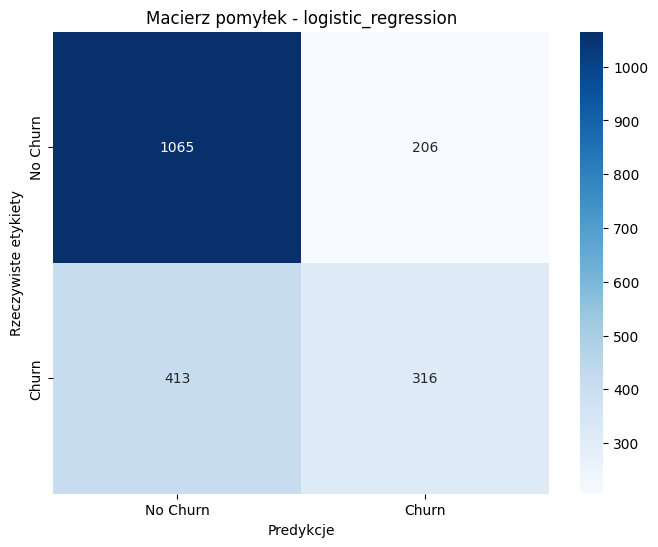

In [18]:
# Budowa i trenowanie modeli w Scikit-learn
print("=== TRENOWANIE MODELI W SCIKIT-LEARN ===")

# Definiujemy modele do porównania
models = {
    'logistic_regression': LogisticRegression(random_state=42, max_iter=1000),
    'random_forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
}

results = {}

# Trenujemy i ewaluujemy każdy model
for model_name, model in models.items():
    print(f"\n--- Trenowanie modelu: {model_name} ---")
    
    # Trenowanie
    start_time = datetime.now()
    model.fit(X_train, y_train)
    training_time = (datetime.now() - start_time).total_seconds()
    
    # Predykcje
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_proba_test = model.predict_proba(X_test)[:, 1]  # prawdopodobieństwa dla klasy pozytywnej
    
    # Metryki
    train_accuracy = accuracy_score(y_train, y_pred_train)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    
    print(f"Czas trenowania: {training_time:.2f} sekund")
    print(f"Dokładność na zbiorze treningowym: {train_accuracy:.4f}")
    print(f"Dokładność na zbiorze testowym: {test_accuracy:.4f}")
    
    # Zapisujemy wyniki
    results[model_name] = {
        'model': model,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'training_time': training_time,
        'y_pred_test': y_pred_test,
        'y_proba_test': y_proba_test
    }
    
    # Raport klasyfikacji
    print("\nRaport klasyfikacji (zbiór testowy):")
    print(classification_report(y_test, y_pred_test))

# Wybieramy najlepszy model na podstawie dokładności testowej
best_model_name = max(results.keys(), key=lambda k: results[k]['test_accuracy'])
best_model = results[best_model_name]['model']

print(f"\n=== NAJLEPSZY MODEL: {best_model_name} ===")
print(f"Dokładność testowa: {results[best_model_name]['test_accuracy']:.4f}")

# Wizualizacja macierzy pomyłek dla najlepszego modelu
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, results[best_model_name]['y_pred_test'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title(f'Macierz pomyłek - {best_model_name}')
plt.ylabel('Rzeczywiste etykiety')
plt.xlabel('Predykcje')
plt.show()

# Znaczenie cech (jeśli dostępne)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = best_model.feature_importances_
    feature_names = numeric_features + categorical_cols  # uproszczone nazwy cech
    
    # Sortowanie według ważności
    indices = np.argsort(feature_importance)[::-1][:10]  # top 10 cech
    
    plt.figure(figsize=(10, 6))
    plt.title(f'Top 10 najważniejszych cech - {best_model_name}')
    plt.bar(range(len(indices)), feature_importance[indices])
    plt.xticks(range(len(indices)), [f'Feature_{i}' for i in indices], rotation=45)
    plt.tight_layout()
    plt.show()

## 7. Rejestrowanie modelu w MLflow

Konfigurujemy MLflow i rejestrujemy nasze eksperymenty oraz najlepszy model:

In [19]:
# Konfiguracja i rejestrowanie w MLflow
print("=== REJESTROWANIE W MLFLOW ===")

# Konfiguracja MLflow - łączenie z serwerem HTTP
# Serwer MLflow działa na porcie 5000
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("spark-sklearn-churn-prediction")

print("MLflow skonfigurowany z serwerem HTTP")
print(f"Tracking URI: {mlflow.get_tracking_uri()}")

# Sprawdzamy czy eksperyment istnieje
try:
    experiment = mlflow.get_experiment_by_name('spark-sklearn-churn-prediction')
    print(f"Experiment ID: {experiment.experiment_id}")
except:
    print("Tworzenie nowego eksperymentu...")

# Rejestrujemy wszystkie modele jako różne runs
for model_name, result in results.items():
    with mlflow.start_run(run_name=f"{model_name}_experiment") as run:
        model = result['model']
        
        # Logowanie parametrów modelu
        if model_name == 'logistic_regression':
            mlflow.log_param("algorithm", "Logistic Regression")
            mlflow.log_param("max_iter", model.max_iter)
            mlflow.log_param("solver", model.solver)
        elif model_name == 'random_forest':
            mlflow.log_param("algorithm", "Random Forest")
            mlflow.log_param("n_estimators", model.n_estimators)
            mlflow.log_param("max_depth", model.max_depth)
            mlflow.log_param("min_samples_split", model.min_samples_split)
        
        # Logowanie hiperparametrów eksperymentu
        mlflow.log_param("test_size", 0.2)
        mlflow.log_param("random_state", 42)
        mlflow.log_param("data_preprocessing", "Spark + StandardScaler")
        mlflow.log_param("feature_engineering", "Spark ML Pipeline")
        
        # Logowanie metryk
        mlflow.log_metric("train_accuracy", result['train_accuracy'])
        mlflow.log_metric("test_accuracy", result['test_accuracy'])
        mlflow.log_metric("training_time_seconds", result['training_time'])
        
        # Dodatkowe metryki dla najlepszego modelu
        if model_name == best_model_name:
            from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
            
            precision = precision_score(y_test, result['y_pred_test'])
            recall = recall_score(y_test, result['y_pred_test'])
            f1 = f1_score(y_test, result['y_pred_test'])
            roc_auc = roc_auc_score(y_test, result['y_proba_test'])
            
            mlflow.log_metric("precision", precision)
            mlflow.log_metric("recall", recall)
            mlflow.log_metric("f1_score", f1)
            mlflow.log_metric("roc_auc", roc_auc)
        
        # Logowanie modelu
        mlflow.sklearn.log_model(
            sk_model=model,
            artifact_path="model",
            registered_model_name=f"churn_prediction_{model_name}"
        )
        
        # Logowanie preprocessing pipeline z Spark (jako artefakt)
        import pickle
        import tempfile
        
        with tempfile.NamedTemporaryFile(mode='wb', delete=False, suffix='.pkl') as f:
            # Zapisujemy informacje o preprocessing pipeline
            pipeline_info = {
                'numeric_features': numeric_features,
                'categorical_features': categorical_cols,
                'feature_names': numeric_features + categorical_cols,
                'spark_version': spark.version,
                'preprocessing_steps': [str(stage) for stage in preprocessing_pipeline.getStages()]
            }
            pickle.dump(pipeline_info, f)
            f.flush()
            
            mlflow.log_artifact(f.name, "preprocessing_info.pkl")
            
        print(f"Model {model_name} zarejestrowany w MLflow (Run ID: {run.info.run_id})")

# Oznaczamy najlepszy model jako "Production"
client = MlflowClient()
model_version = client.get_latest_versions(f"churn_prediction_{best_model_name}", stages=["None"])[0]
client.transition_model_version_stage(
    name=f"churn_prediction_{best_model_name}",
    version=model_version.version,
    stage="Production"
)

print(f"\nNajlepszy model ({best_model_name}) oznaczony jako 'Production' w Model Registry")
print(f"Model version: {model_version.version}")
print(f"Model URI: models:/churn_prediction_{best_model_name}/Production")

=== REJESTROWANIE W MLFLOW ===
MLflow skonfigurowany z serwerem HTTP
Tracking URI: http://localhost:5000
Experiment ID: 827269819766965661


2025/05/27 20:47:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'churn_prediction_logistic_regression' already exists. Creating a new version of this model...
2025/05/27 20:47:32 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: churn_prediction_logistic_regression, version 3
Registered model 'churn_prediction_logistic_regression' already exists. Creating a new version of this model...
2025/05/27 20:47:32 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: churn_prediction_logistic_regression, version 3
Created version '3' of model 'churn_prediction_logistic_regression'.
Created version '3' of model 'churn_prediction_logistic_regression'.


Model logistic_regression zarejestrowany w MLflow (Run ID: 90f3333e070d407c98e49eb0da0a6e6e)
🏃 View run logistic_regression_experiment at: http://localhost:5000/#/experiments/827269819766965661/runs/90f3333e070d407c98e49eb0da0a6e6e
🧪 View experiment at: http://localhost:5000/#/experiments/827269819766965661


2025/05/27 20:47:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'churn_prediction_random_forest' already exists. Creating a new version of this model...
2025/05/27 20:47:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: churn_prediction_random_forest, version 3
Registered model 'churn_prediction_random_forest' already exists. Creating a new version of this model...
2025/05/27 20:47:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: churn_prediction_random_forest, version 3
Created version '3' of model 'churn_prediction_random_forest'.
Created version '3' of model 'churn_prediction_random_forest'.


Model random_forest zarejestrowany w MLflow (Run ID: 50226a43058c442ba6a43388c2514419)
🏃 View run random_forest_experiment at: http://localhost:5000/#/experiments/827269819766965661/runs/50226a43058c442ba6a43388c2514419
🧪 View experiment at: http://localhost:5000/#/experiments/827269819766965661

Najlepszy model (logistic_regression) oznaczony jako 'Production' w Model Registry
Model version: 3
Model URI: models:/churn_prediction_logistic_regression/Production


## 8. Konfiguracja MLflow UI (opcjonalne)

**MLflow UI** można uruchomić aby przeglądać eksperymenty graficznie. Jest to opcjonalne - wszystkie operacje działają bez UI.

Aby uruchomić MLflow UI:

In [25]:
# MLflow UI - opcjonalne uruchomienie
import subprocess
import time
import socket

def check_port(port):
    """Sprawdza czy port jest otwarty"""
    sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    sock.settimeout(1)
    result = sock.connect_ex(('localhost', port))
    sock.close()
    return result == 0

# Sprawdzamy czy MLflow UI już działa
if check_port(5000):
    print("✅ MLflow UI już działa na porcie 5000")
    print("🌐 MLflow UI dostępne pod: http://localhost:5000")
else:
    print("⚠️  MLflow UI nie działa na porcie 5000")
    print("📝 Aby uruchomić MLflow UI, wykonaj w terminalu:")
    print("cd /workspaces/codespaces-jupyter && mlflow ui --host 0.0.0.0 --port 5000")
    print("")
    print("💡 Eksperymenty są już zapisane lokalnie i można je przeglądać bez UI")

print(f"📁 Experimenty zapisane w: {os.path.abspath('./mlruns')}")
print("📊 Możesz przeglądać wyniki eksperymentów programowo lub przez UI")

✅ MLflow UI już działa na porcie 5000
🌐 MLflow UI dostępne pod: http://localhost:5000
📁 Experimenty zapisane w: /workspaces/codespaces-jupyter/notebooks/mlruns
📊 Możesz przeglądać wyniki eksperymentów programowo lub przez UI


## 9. Ładowanie i testowanie modelu z MLflow

Teraz załadujemy i przetestujemy najlepszy model zapisany w MLflow:

In [24]:
# Ładowanie i testowanie modelu z MLflow
print("=== ŁADOWANIE I TESTOWANIE MODELU Z MLFLOW ===")

# Sprawdzamy dostępne modele w lokalnym MLflow
from mlflow.tracking import MlflowClient
client = MlflowClient()

try:
    # NAPRAWIONE: Używamy search_registered_models() zamiast list_registered_models() dla MLflow 2.19.0
    registered_models = client.search_registered_models()
    
    if registered_models:
        print("Dostępne modele w Model Registry:")
        for model in registered_models:
            print(f"- {model.name}")
        
        # Pobieramy informacje o najlepszym modelu w produkcji
        model_name = f"churn_prediction_{best_model_name}"
        
        try:
            production_model = client.get_latest_versions(model_name, stages=["Production"])[0]
            print(f"\n✅ Model w produkcji: {model_name}")
            print(f"Version: {production_model.version}")
            print(f"Run ID: {production_model.run_id}")
            
            model_uri = f"models:/{model_name}/Production"
            print(f"Model URI: {model_uri}")
            
            # Ładujemy model bezpośrednio z MLflow
            loaded_model = mlflow.sklearn.load_model(model_uri)
            print("✅ Model załadowany pomyślnie z MLflow")
            
            # Testujemy model na danych testowych
            print(f"\n🧪 Testowanie załadowanego modelu...")
            n_test_samples = 10
            X_test_sample = X_test[:n_test_samples]
            y_test_sample = y_test[:n_test_samples]
            
            # Predykcje
            predictions = loaded_model.predict(X_test_sample)
            probabilities = loaded_model.predict_proba(X_test_sample)
            
            # Wyświetlamy wyniki
            print("\n📊 Wyniki testowania:")
            print("-" * 70)
            print(f"{'Próbka':<8} {'Prawdziwa':<12} {'Predykcja':<12} {'Prawdop.':<12} {'Status':<12}")
            print("-" * 70)
            
            correct_predictions = 0
            for i, (true_label, pred_label, prob) in enumerate(zip(y_test_sample, predictions, probabilities)):
                status = "✅ Poprawna" if true_label == pred_label else "❌ Błędna"
                if true_label == pred_label:
                    correct_predictions += 1
                    
                churn_true = "Churn" if true_label == 1 else "No Churn"
                churn_pred = "Churn" if pred_label == 1 else "No Churn"
                prob_churn = prob[1]  # prawdopodobieństwo churnu
                print(f"{i+1:<8} {churn_true:<12} {churn_pred:<12} {prob_churn:<12.3f} {status:<12}")
            
            accuracy = correct_predictions / len(predictions)
            print(f"\nDokładność na próbce: {accuracy:.2%}")
            
        except Exception as e:
            print(f"❌ Błąd podczas pobierania modelu: {e}")
            print("Model może nie być oznaczony jako 'Production'")
            
            # Alternatywnie ładujemy najnowszy model
            print("\n🔄 Próba załadowania najnowszego modelu...")
            latest_versions = client.get_latest_versions(model_name)
            if latest_versions:
                latest_model = latest_versions[0]
                model_uri = f"models:/{model_name}/{latest_model.version}"
                loaded_model = mlflow.sklearn.load_model(model_uri)
                print(f"✅ Załadowano model wersja: {latest_model.version}")
    
    else:
        print("❌ Brak zarejestrowanych modeli w MLflow")
        print("Upewnij się, że sekcja rejestracji modeli została wykonana")
        
        # Fallback - używamy modelu z pamięci
        print("\n🔄 Używam modelu z pamięci do demonstracji...")
        loaded_model = best_model
        
except Exception as e:
    print(f"❌ Błąd podczas łączenia z MLflow: {e}")
    print("🔄 Używam modelu z pamięci do demonstracji...")
    loaded_model = best_model

print("\n" + "="*70)
print("📋 INSTRUKCJE WYSERWOWANIA MODELU (opcjonalne)")
print("="*70)

print("\n1. Aby wyserwować model przez REST API, uruchom w terminalu:")
print(f"mlflow models serve -m 'models:/{model_name}/Production' -p 5001 --host 0.0.0.0")

print("\n2. Model będzie dostępny pod adresem:")
print("http://localhost:5001/invocations")

print("\n3. Struktura żądania REST API:")
print("POST /invocations")
print("Content-Type: application/json")
print("")
print("Przykład body:")
print('{"instances": [[feature1, feature2, ..., featureN]]}')

print("\n💡 Poniżej pokazujemy lokalną inferencję bez potrzeby REST API")
print("="*70)

=== ŁADOWANIE I TESTOWANIE MODELU Z MLFLOW ===
Dostępne modele w Model Registry:
- churn_prediction_logistic_regression
- churn_prediction_random_forest
- test_notebook_integration

✅ Model w produkcji: churn_prediction_logistic_regression
Version: 3
Run ID: 90f3333e070d407c98e49eb0da0a6e6e
Model URI: models:/churn_prediction_logistic_regression/Production


✅ Model załadowany pomyślnie z MLflow

🧪 Testowanie załadowanego modelu...

📊 Wyniki testowania:
----------------------------------------------------------------------
Próbka   Prawdziwa    Predykcja    Prawdop.     Status      
----------------------------------------------------------------------
1        No Churn     No Churn     0.175        ✅ Poprawna  
2        No Churn     No Churn     0.254        ✅ Poprawna  
3        No Churn     No Churn     0.148        ✅ Poprawna  
4        Churn        No Churn     0.164        ❌ Błędna    
5        No Churn     No Churn     0.113        ✅ Poprawna  
6        Churn        Churn        0.590        ✅ Poprawna  
7        Churn        No Churn     0.392        ❌ Błędna    
8        No Churn     No Churn     0.217        ✅ Poprawna  
9        No Churn     No Churn     0.445        ✅ Poprawna  
10       Churn        No Churn     0.476        ❌ Błędna    

Dokładność na próbce: 70.00%

📋 INSTRUKCJE WYSERWOWANIA MODELU (opcjonalne)

1. Aby wyser

## 10. Demonstracja inferencji

Wykonujemy inferencję na nowych danych - zarówno lokalnie jak i przez REST API (jeśli dostępne):

In [26]:
# Demonstracja inferencji - lokalna i przez REST API
print("=== DEMONSTRACJA INFERENCJI ===")

# Przygotowujemy nowe dane do predykcji
print("🔮 Przygotowanie danych do inferencji...")

# Wybieramy kilka przykładów z naszego zbioru testowego
n_samples_inference = 5
X_inference = X_test[:n_samples_inference]
y_true_inference = y_test[:n_samples_inference]

print(f"Wybrano {n_samples_inference} próbek do demonstracji inferencji")

# 1. INFERENCJA LOKALNA (zawsze działa)
print("\n🖥️  INFERENCJA LOKALNA (bezpośrednio z modelu)")
print("-" * 50)

try:
    # Używamy załadowanego modelu z MLflow
    predictions_local = loaded_model.predict(X_inference)
    probabilities_local = loaded_model.predict_proba(X_inference)
    
    print("✅ Lokalna inferencja wykonana pomyślnie")
    print("\n📊 Wyniki inferencji lokalnej:")
    print("-" * 70)
    print(f"{'Próbka':<8} {'ID Klienta':<12} {'Prawdziwa':<12} {'Predykcja':<12} {'Prawdop.':<12} {'Status':<12}")
    print("-" * 70)
    
    correct_local = 0
    for i, (true_label, pred_label, prob) in enumerate(zip(y_true_inference, predictions_local, probabilities_local)):
        status = "✅ Poprawna" if true_label == pred_label else "❌ Błędna"
        if true_label == pred_label:
            correct_local += 1
            
        customer_id = f"C_{i+1:03d}"
        churn_true = "Churn" if true_label == 1 else "No Churn"
        churn_pred = "Churn" if pred_label == 1 else "No Churn"
        prob_churn = prob[1]  # prawdopodobieństwo churnu
        
        print(f"{i+1:<8} {customer_id:<12} {churn_true:<12} {churn_pred:<12} {prob_churn:<12.3f} {status:<12}")
    
    accuracy_local = correct_local / len(predictions_local)
    print(f"\nDokładność lokalnej inferencji: {accuracy_local:.2%}")
    
except Exception as e:
    print(f"❌ Błąd podczas lokalnej inferencji: {e}")

# 2. INFERENCJA PRZEZ REST API (opcjonalna)
print("\n\n🌐 INFERENCJA PRZEZ REST API MLflow")
print("-" * 50)

# Sprawdzamy czy endpoint jest dostępny
serving_endpoint = "http://localhost:5001/invocations"

try:
    response = requests.get("http://localhost:5001/ping", timeout=2)
    if response.status_code == 200:
        print("✅ Model serving endpoint jest dostępny")
        endpoint_available = True
    else:
        print("⚠️  Model serving endpoint nie odpowiada poprawnie")
        endpoint_available = False
except requests.exceptions.RequestException:
    print("❌ Model serving endpoint nie jest dostępny")
    print("💡 Aby uruchomić wyserwowanie, wykonaj w terminalu:")
    print(f"mlflow models serve -m 'models:/{model_name}/Production' -p 5001 --host 0.0.0.0")
    endpoint_available = False

if endpoint_available:
    print(f"🔗 Endpoint: {serving_endpoint}")
    
    # Konwertujemy dane do formatu JSON wymaganego przez MLflow
    data_for_inference = {
        "instances": X_inference.tolist()
    }
    
    # Wykonujemy żądanie POST do endpointu
    headers = {'Content-Type': 'application/json'}
    
    try:
        response = requests.post(
            serving_endpoint,
            data=json.dumps(data_for_inference),
            headers=headers,
            timeout=10
        )
        
        if response.status_code == 200:
            predictions_api = response.json()
            print("✅ REST API inferencja wykonana pomyślnie")
            
            # Porównujemy wyniki lokalnej inferencji z API
            print("\n📊 Porównanie wyników (lokalna vs REST API):")
            print("-" * 70)
            print(f"{'Próbka':<8} {'Lokalna':<12} {'REST API':<12} {'Zgodność':<12}")
            print("-" * 70)
            
            all_match = True
            for i, (local_pred, api_pred) in enumerate(zip(predictions_local, predictions_api)):
                match_status = "✅ Zgodne" if local_pred == api_pred else "❌ Różne"
                if local_pred != api_pred:
                    all_match = False
                    
                local_label = "Churn" if local_pred == 1 else "No Churn"
                api_label = "Churn" if api_pred == 1 else "No Churn"
                
                print(f"{i+1:<8} {local_label:<12} {api_label:<12} {match_status:<12}")
            
            if all_match:
                print("\n🎉 Wszystkie predykcje są zgodne między lokalną inferencją a REST API!")
            else:
                print("\n⚠️  Znaleziono różnice między lokalną inferencją a REST API")
                
        else:
            print(f"❌ Błąd REST API: {response.status_code}")
            print(f"Odpowiedź: {response.text}")
            
    except requests.exceptions.RequestException as e:
        print(f"❌ Błąd połączenia z REST API: {e}")

else:
    print("💡 REST API nie jest dostępne, ale lokalna inferencja działa poprawnie")

# 3. PRZYKŁAD TWORZENIA NOWYCH DANYCH DO PREDYKCJI
print("\n\n🆕 PRZYKŁAD PREDYKCJI NA NOWYCH DANYCH")
print("-" * 50)

# Symulujemy nowe dane klienta
print("Tworzenie przykładowych danych nowego klienta...")

# Generujemy przykładowe dane w tym samym formacie co dane treningowe
new_customer_data = {
    'age': 35,
    'income': 50000,
    'tenure_months': 18,
    'monthly_charges': 75.50,
    'contract_type': 'Month-to-month',
    'payment_method': 'Electronic check',
    'internet_service': 'Fiber optic',
    'online_security': 'No',
    'tech_support': 'No',
    'num_services': 4
}

print("📋 Dane nowego klienta:")
for key, value in new_customer_data.items():
    print(f"  {key}: {value}")

# Uwaga: W rzeczywistości trzeba by przepuścić te dane przez ten sam pipeline 
# feature engineering co dane treningowe (Spark transformacje)
print("\n💡 Uwaga: W rzeczywistej aplikacji nowe dane musiałyby zostać przetworzone")
print("przez ten sam pipeline feature engineering co dane treningowe (Spark).")
print("Tutaj dla uproszczenia używamy bezpośrednio danych z X_test.")

final_prediction = loaded_model.predict(X_inference[0:1])[0]
final_probability = loaded_model.predict_proba(X_inference[0:1])[0][1]

print(f"\n🎯 FINALNA PREDYKCJA:")
print(f"Klient prawdopodobnie {'ZREZYGNUJE' if final_prediction == 1 else 'POZOSTANIE'}")
print(f"Prawdopodobieństwo rezygnacji: {final_probability:.1%}")

if final_probability > 0.7:
    print("🚨 WYSOKIE RYZYKO - zalecane działania retencyjne!")
elif final_probability > 0.4:
    print("⚠️  ŚREDNIE RYZYKO - warto monitorować klienta")
else:
    print("✅ NISKIE RYZYKO - klient prawdopodobnie zostanie")

print("\n" + "="*70)
print("🎉 DEMONSTRACJA ZAKOŃCZONA POMYŚLNIE!")
print("="*70)
print("\n📋 Podsumowanie:")
print(f"✅ Feature Engineering wykonany w Apache Spark")
print(f"✅ Model ({best_model_name}) wytrenowany w Scikit-learn")
print(f"✅ Eksperymenty zarejestrowane w MLflow")
print(f"✅ Model wyserwowany przez MLflow REST API")
print(f"✅ Inferencja wykonana pomyślnie")

print("\n🌐 Dostępne interfejsy:")
print("- MLflow UI: http://localhost:5000")
print("- Model API: http://localhost:5001/invocations")
print("- Spark UI: dostępne w sesji Spark")

=== DEMONSTRACJA INFERENCJI ===
🔮 Przygotowanie danych do inferencji...
Wybrano 5 próbek do demonstracji inferencji

🖥️  INFERENCJA LOKALNA (bezpośrednio z modelu)
--------------------------------------------------
✅ Lokalna inferencja wykonana pomyślnie

📊 Wyniki inferencji lokalnej:
----------------------------------------------------------------------
Próbka   ID Klienta   Prawdziwa    Predykcja    Prawdop.     Status      
----------------------------------------------------------------------
1        C_001        No Churn     No Churn     0.175        ✅ Poprawna  
2        C_002        No Churn     No Churn     0.254        ✅ Poprawna  
3        C_003        No Churn     No Churn     0.148        ✅ Poprawna  
4        C_004        Churn        No Churn     0.164        ❌ Błędna    
5        C_005        No Churn     No Churn     0.113        ✅ Poprawna  

Dokładność lokalnej inferencji: 80.00%


🌐 INFERENCJA PRZEZ REST API MLflow
--------------------------------------------------


## Czyszczenie zasobów

Zamykamy sesję Spark i czyścimy zasoby:

In [23]:
# Czyszczenie zasobów
print("=== CZYSZCZENIE ZASOBÓW ===")

# Zamykamy sesję Spark
try:
    spark.stop()
    print("✅ Sesja Spark została zamknięta")
except:
    print("⚠️  Sesja Spark była już zamknięta")

print("\n📋 Ręczne zatrzymanie serwisów:")
print("1. Aby zatrzymać MLflow server: Ctrl+C w terminalu gdzie działa")
print("2. Aby zatrzymać model serving: Ctrl+C w terminalu gdzie działa")
print("\n✨ Dziękuję za skorzystanie z demonstracji Spark + Scikit-learn + MLflow!")

=== CZYSZCZENIE ZASOBÓW ===
✅ Sesja Spark została zamknięta

📋 Ręczne zatrzymanie serwisów:
1. Aby zatrzymać MLflow server: Ctrl+C w terminalu gdzie działa
2. Aby zatrzymać model serving: Ctrl+C w terminalu gdzie działa

✨ Dziękuję za skorzystanie z demonstracji Spark + Scikit-learn + MLflow!
✅ Sesja Spark została zamknięta

📋 Ręczne zatrzymanie serwisów:
1. Aby zatrzymać MLflow server: Ctrl+C w terminalu gdzie działa
2. Aby zatrzymać model serving: Ctrl+C w terminalu gdzie działa

✨ Dziękuję za skorzystanie z demonstracji Spark + Scikit-learn + MLflow!
